In [114]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
from bitmex_backtest import Backtest
import requests
import matplotlib.pyplot as plt

# Getting Data

In [70]:
funding_rates_df = pd.read_csv('data/funding.csv', parse_dates=True)
funding_rates_df['timestamp'] = pd.to_datetime(funding_rates_df['timestamp'], dayfirst=True)
#funding_rates_df.set_index('timestamp', inplace=True)

In [166]:
def trade_bucket(startDate='2019-01-09'):
    start = 0
    df = pd.DataFrame()
    data = True
    counter = 1
    
    while data:
        api_call_url = 'https://www.bitmex.com/api/v1/trade/bucketed?binSize=1h&partial=false&symbol=XBTUSD&count=1000&start=' + str(
                       start) +'&reverse=true&startTime=' + startDate
        r = requests.get(api_call_url)
        if r.status_code != 200:
            r.raise_for_status()
        data = r.json()
        if data:
            temp_df = pd.DataFrame(data)
            df = df.append(temp_df)
            start += 1000
        if counter < 30:
            counter += 1
        else:
            sleep(60)
            counter = 1
    df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
    # df.set_index('timestamp', inplace=True)
    return df

In [167]:
trade_df = trade_bucket()

trade_df.shape

(8772, 13)

# Backtest

In [ ]:
# Example
def weightage_backtest(indicators={}):
    """ indicators (list) : contains time series of indicators
    """ 
    num = len(indicators)
    long_grad = np.ones(num)
    long_const = np.zeros(num)
    short_grad = np.ones(num)
    short_const = np.zeros(num)

    itr = 0
    max_profit = 0
   
    while itr < 100:
        long_sum = long_grad*np.array([indicators['funding_rates_ema'], indicators['MYVWAP']]) + long_const
        short_sum = short_grad*np.array([indicators['funding_rates_ema'], indicators['MYVWAP']]) + short_const

        bt.sell_exit = bt.buy_entry = (short_sum < 0)
        bt.buy_exit = bt.sell_entry = (long_sum > 0)
        series = bt.run()

        ### Learning Algorithm to update long_grad, long_const, short_grad, short_const
        
        max_profit = max(max_profit, series['total profit'])
        itr += 1

    return long_grad, long_const, short_grad, short_const

In [ ]:
bt = Backtest()
bt.df = trade_df.merge(funding_rates_df, how='outer', on='timestamp').dropna()
bt.df.rename(columns={"timestamp":"t","low": "L", "high": "H", "open": "O", "close": "C", "volume":'V'}, inplace=True)
automated_backtest(ema_start=7, ema_end=20)

# Data Preprocessing

In [229]:
funding_rates_df['EMA'] = funding_rates_df['fundingRate'].ewm(span=14, min_periods=14).mean()

In [249]:
df_train = funding_rates_df['EMA'][funding_rates_df['timestamp'] < "2019-05-01"].to_frame(name="vwap").dropna()
df_train.shape

(3190, 1)

In [236]:
df_val = funding_rates_df['EMA'][(funding_rates_df['timestamp'] >= "2019-06-01") & (funding_rates_df['timestamp'] < "2019-09-01")].to_frame(name="EMA")
df_val.shape

(276, 1)

In [237]:
df_test = funding_rates_df['EMA'][funding_rates_df['timestamp'] > "2019-09-01"].to_frame(name="EMA")
df_test.shape

(391, 1)

In [238]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_val)
test_arr = scaler.transform(df_test)

In [239]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [250]:
from torch.autograd import Variable

seq_len = 50

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

# LSTM

In [242]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [243]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})

def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

In [251]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [252]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)
optimization_1.plot_losses()

Epoch 1 Train loss: nan. Validation loss: nan. Avg future: 0.00. Elapsed time: 1.85s.
Epoch 2 Train loss: nan. Validation loss: nan. Avg future: 0.00. Elapsed time: 1.84s.


KeyboardInterrupt: 

In [246]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=20)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

c:\users\laide\miniconda3\envs\xbt_aggregator\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([20, 50])) that is different to the input size (torch.Size([20, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (20) must match the size of tensor b (50) at non-singleton dimension 1

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[:1000].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[1000:2000].plot(ax=axes[1], figsize=(14, 7))

In [ ]:
x_sample = x_test[0].reshape(1, -1)
y_sample = df_test.vwap[:1100]
 
y_pred1 = generate_sequence(scaler, optimization_1.model, x_sample)
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred1[0][:100], color="blue", lw=2, label="Predicted VWAP")
plt.plot(range(100, 1100), y_pred1[0][100:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(range(0, 1100), y_sample, color="red", label="Actual VWAP")
plt.legend()

## Teacher Forcing

In [194]:
model_2 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_2 = nn.MSELoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = optim.lr_scheduler.StepLR(optimizer_2, step_size=5, gamma=0.1)
optimization_2 = Optimization(model_2, loss_fn_2,  optimizer_2, scheduler_2)
optimization_2.train(x_train, y_train, x_val, y_val, do_teacher_forcing=True)

Epoch 1 Train loss: 0.84. Validation loss: 3.14. Avg future: 23.27. Elapsed time: 5.40s.
Epoch 2 Train loss: 0.56. Validation loss: 2.28. Avg future: 25.62. Elapsed time: 5.34s.
Epoch 3 Train loss: 0.36. Validation loss: 1.02. Avg future: 24.10. Elapsed time: 5.49s.
Epoch 4 Train loss: 0.13. Validation loss: 0.63. Avg future: 22.88. Elapsed time: 5.50s.
Epoch 5 Train loss: 0.10. Validation loss: 0.66. Avg future: 22.12. Elapsed time: 5.41s.
Epoch 6 Train loss: 0.08. Validation loss: 0.61. Avg future: 25.32. Elapsed time: 5.40s.
Epoch 7 Train loss: 0.08. Validation loss: 0.57. Avg future: 25.10. Elapsed time: 5.37s.
Epoch 8 Train loss: 0.08. Validation loss: 0.53. Avg future: 24.88. Elapsed time: 5.20s.
Epoch 9 Train loss: 0.07. Validation loss: 0.51. Avg future: 26.12. Elapsed time: 5.34s.
Epoch 10 Train loss: 0.07. Validation loss: 0.48. Avg future: 26.02. Elapsed time: 5.31s.
Epoch 11 Train loss: 0.06. Validation loss: 0.48. Avg future: 21.68. Elapsed time: 5.25s.
Epoch 12 Train loss

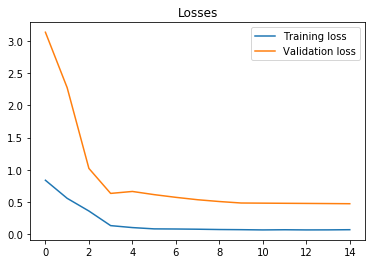

In [195]:
optimization_2.plot_losses()

Test loss 0.0247


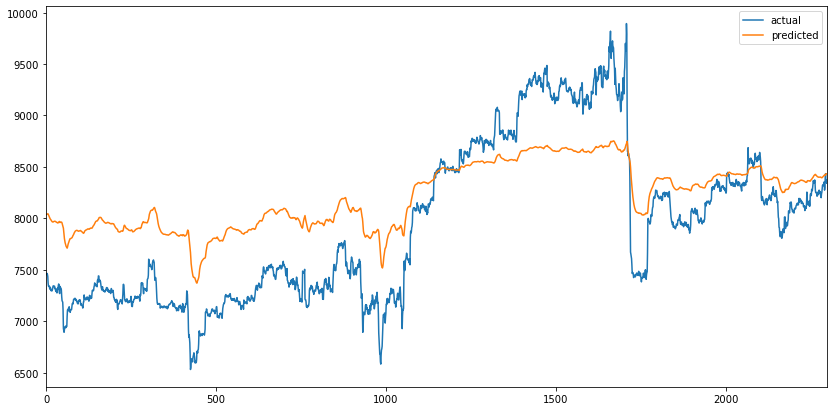

In [196]:
actual_2, predicted_2, test_loss_2 = optimization_2.evaluate(x_test, y_test, batch_size=100, future=5)
df_result_2 = to_dataframe(actual_2, predicted_2)
df_result_2 = inverse_transform(scaler, df_result_2, ["actual", "predicted"])
df_result_2.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_2)

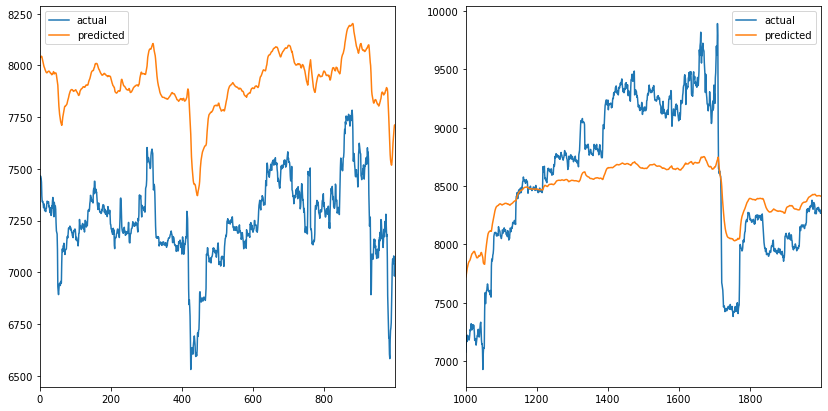

In [199]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_2.iloc[:1000].plot(ax=axes[0], figsize=(14, 7))
df_result_2.iloc[1000:2000].plot(ax=axes[1], figsize=(14, 7))

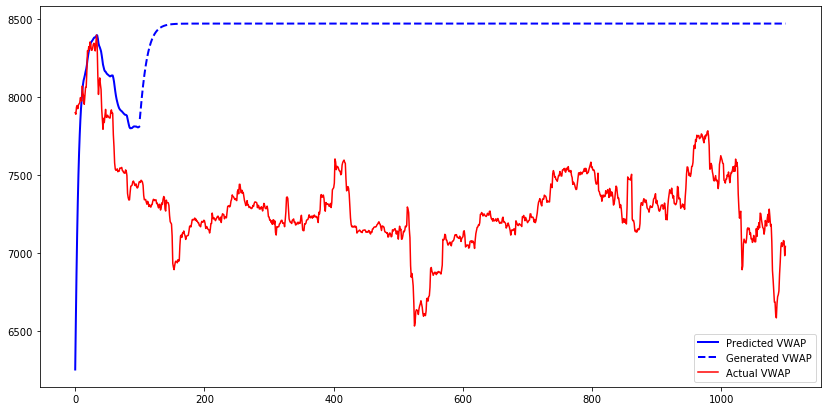

In [200]:
y_pred2 = generate_sequence(scaler, optimization_2.model, x_sample)
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred2[0][:100], color="blue", lw=2, label="Predicted VWAP")
plt.plot(range(100, 1100), y_pred2[0][100:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(range(0, 1100), y_sample, color="red", label="Actual VWAP")
plt.legend()